### Waveforms

In [19]:
run_number = 6341
file_number = 2325
trigger = 'trigger1'

#### ZS data with sources, trigger at high energy

## Imports

In [2]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
import seaborn as sns
import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-09-23 20:48:45


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
sns.set()

In [7]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [4]:
from invisible_cities.reco.dst_functions  import load_dst

In [5]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

## NB functions

In [7]:
def plot_csum_csum_mau(csum, csum_mau,
                            t_min      =    0,
                            t_max      = 1200,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6)):
    """Plot signal versus time in mus (tmin, tmax in mus). """
    plt.figure(figsize=figsize)
    tstep = 25 # in ns
    PMTWL = csum.shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([t_min, t_max])
    ax1.set_ylim([signal_min, signal_max])
    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "signal (pes/adc)")
    plt.plot(signal_t, csum, 'b')
    plt.plot(signal_t, csum_mau, 'r')

In [43]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [9]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [10]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


In [47]:
def plot_sipm_map(sipm_cal, t_min=0, t_max=1300, zoom=False):
    
    sipm_sums_w = np.sum(sipm_cal[:, t_min:t_max], axis=1)
    
    plt.figure()
    sipms_ = sipm_sums_w > 0 
    x = xs[sipms_]
    y = ys[sipms_]
    q = sipm_sums_w[sipms_]
    #print(np.argwhere(sipms_))
    plt.scatter(x, y, s=10, c=q, cmap="jet")
    
    if not zoom:
        plt.xlim(-200, 200)
        plt.ylim(-200, 200)
    plt.colorbar()

In [49]:
def plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min, t_max):

    sipm_sums = np.sum(sipm_cal, axis=0)
    
    t = np.arange(len(cwf_sum)) / 40
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, cwf_sum)
    plt.xlim(t_min , t_max )

    plt.subplot(2, 1, 2)
    plt.plot(sipm_sums)
    plt.xlim(t_min, t_max)

## Data base

In [8]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [9]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [10]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,24.8956,0.77,9.65758
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,26.1527,0.00,10.98320
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,28.0751,0.81,10.48550
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,28.0198,0.00,10.76870
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,32.5408,0.75,12.25110
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,24.9557,0.75,9.55162
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,27.9666,0.00,10.33970
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,35.8262,0.00,13.53750
8,8,2,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,26.1784,0.00,9.52523
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,28.0920,0.00,9.82717


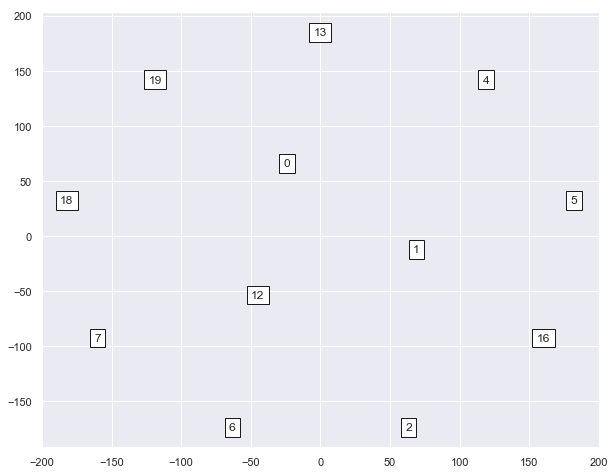

In [11]:
mpl.draw_pmt_map(run_number)

In [12]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [13]:
adc_to_pes

array([24.8956, 26.1527, 28.0751, 28.0198, 32.5408, 24.9557, 27.9666,
       35.8262, 26.1784, 28.092 , 23.6226, 24.9109])

In [14]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

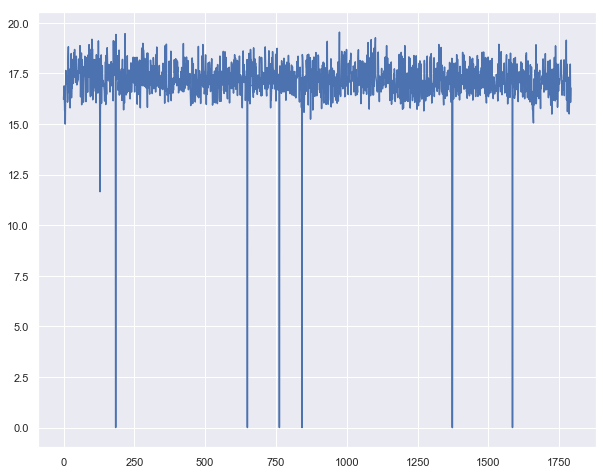

In [15]:
plt.plot(adc_to_pes_sipm)

## Input file

In [20]:
filename = f'$IC_DATA/wfm/{run_number}/run_{run_number}_{file_number}_{trigger}_waveforms.h5'
h5rwf = tb.open_file(os.path.expandvars(filename), "r") 

In [21]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf

In [22]:
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape

In [23]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 296
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


In [24]:
evts = h5rwf.root.Run.events[:]

## S1 and S2 parameters

In [25]:
s1params = S12Params(time = minmax(min    = 100 * units.mus,
                                   max    = 620 * units.mus),
                           stride = 5,
                           length = minmax(min = 5, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [26]:
s2params = S12Params(time = minmax(min    = 100 * units.mus,
                                   max    = 1300 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Event 0

In [27]:
event=0

In [28]:
evts[event]

(763117, 1537709886886)

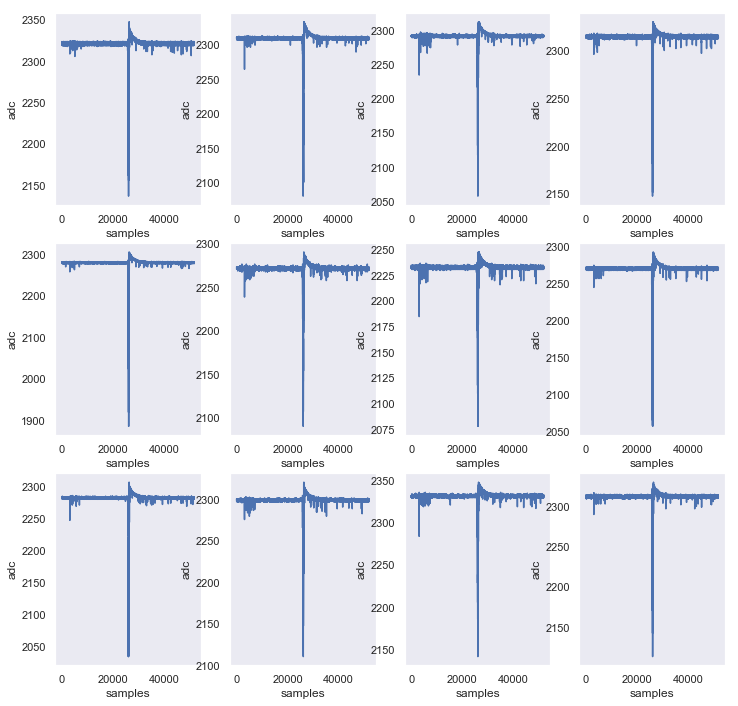

In [29]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

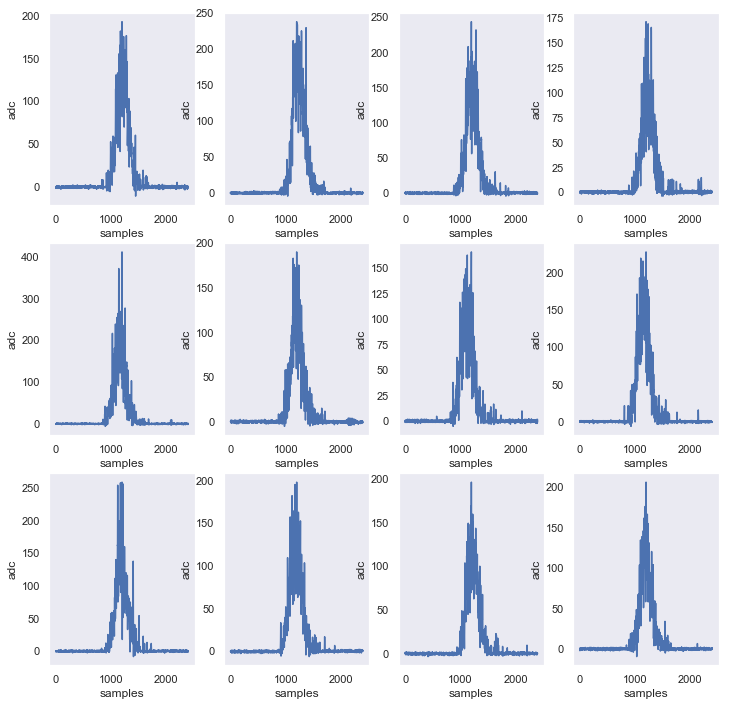

In [30]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

- Calibrated signal in all PMTs

In [31]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


- Calibrated sum

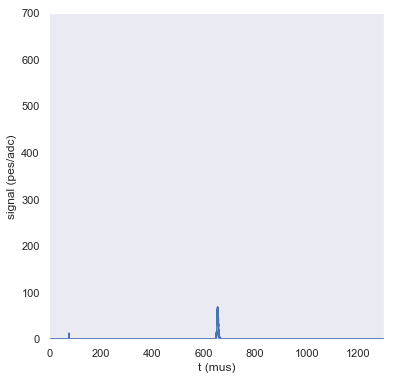

In [32]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  700,
                            figsize=(6,6))

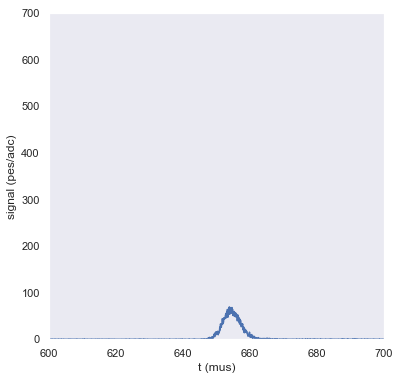

In [33]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  700,
                            figsize=(6,6))

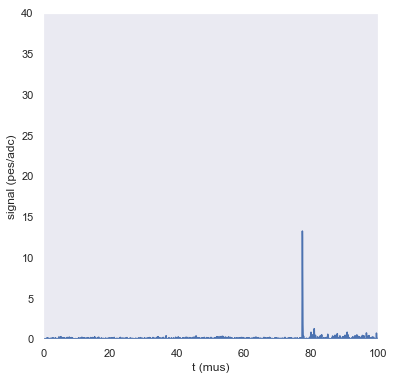

In [35]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 100,
                            signal_min =    0,
                            signal_max =  40,
                            figsize=(6,6))

#### Search for S1 and S2a

In [36]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)

In [37]:
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

In [38]:
s1s

[]

In [39]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 2.0 * units.pes)

In [40]:
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

In [41]:
s2s

[
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 16
        Times: [647.94922137 648.99292028 649.91213811 650.94645625 651.8995609
 652.88147405 653.87083793 654.8528685  655.8518077  656.82484084
 657.80915391 658.81570341 659.83172098 660.838717   661.80093458
 662.48020954] µs
        Time @ max energy: 653.8708379313965
        Width: 14.530988174179685 µs
        Height: 2418.6726026460556 pes
        Energy: 15690.723377042485 pes
        Charge: 0.0 pes
        RMS: 2.5857426485462516 µs]

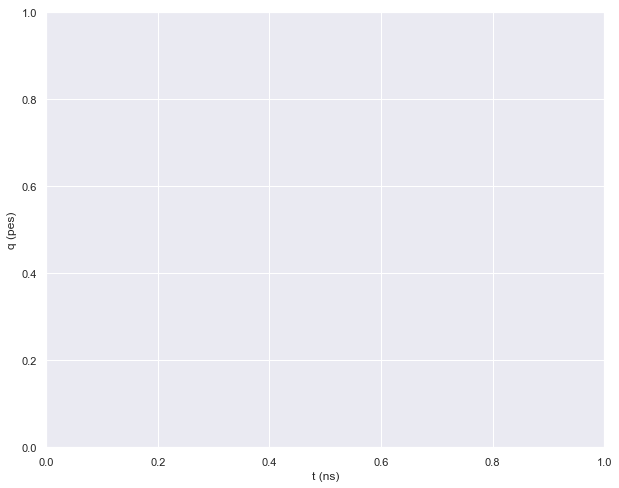

In [44]:
plot_S12(s1s)

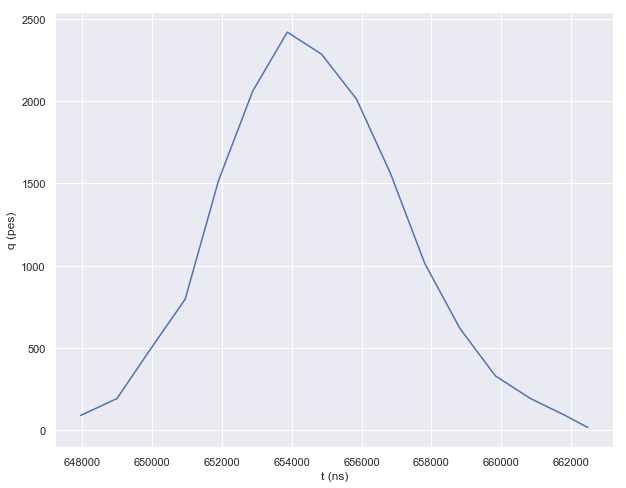

In [45]:
plot_S12(s2s)

In [46]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)

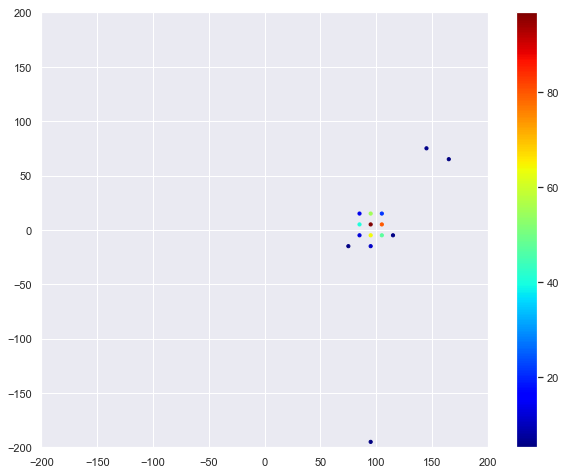

In [48]:
plot_sipm_map(sipm_cal)

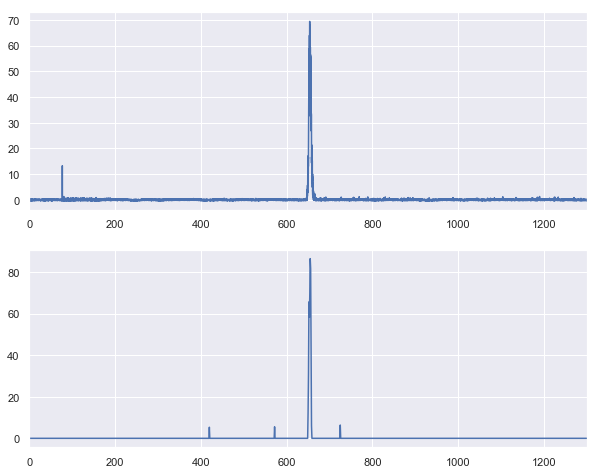

In [50]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

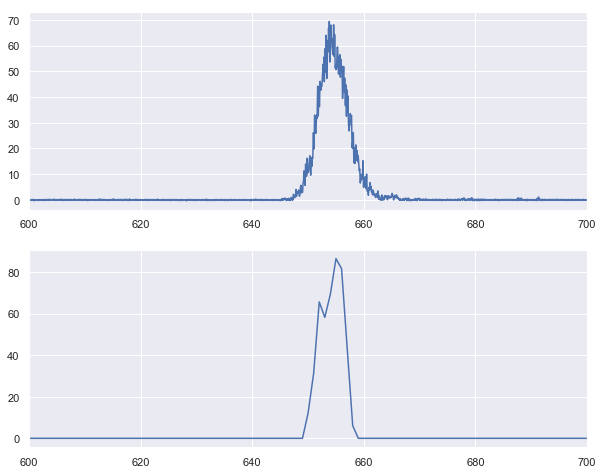

In [51]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=600, t_max=700)

## Event 1

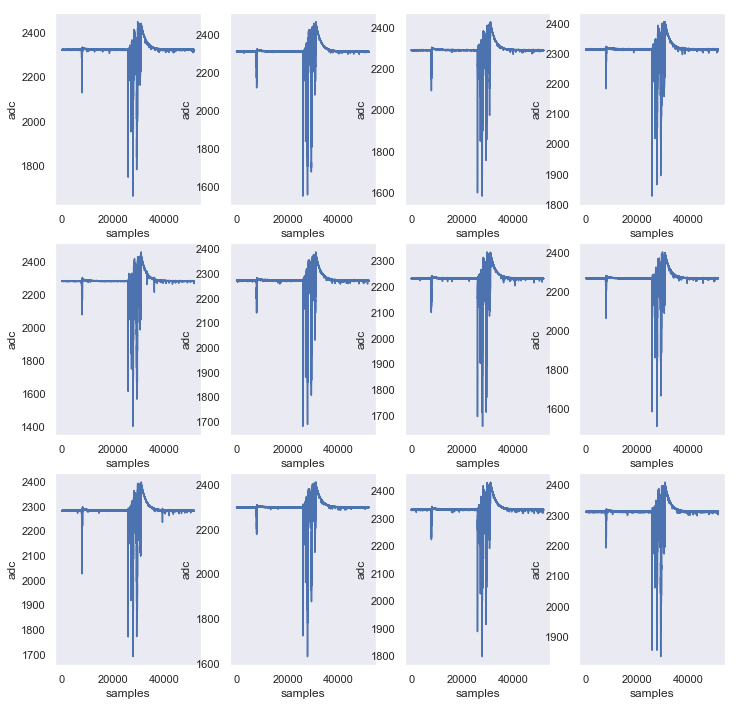

In [52]:
event=1
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

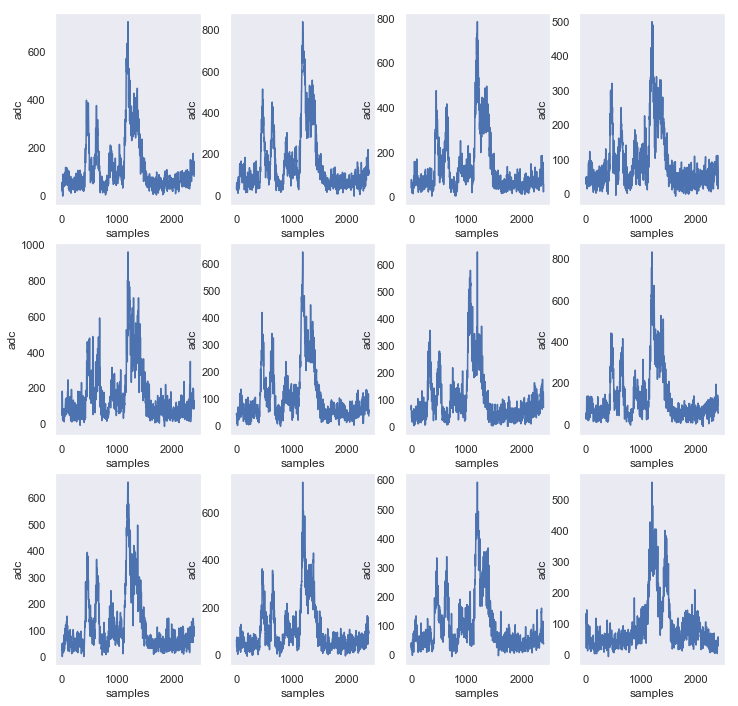

In [53]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [54]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


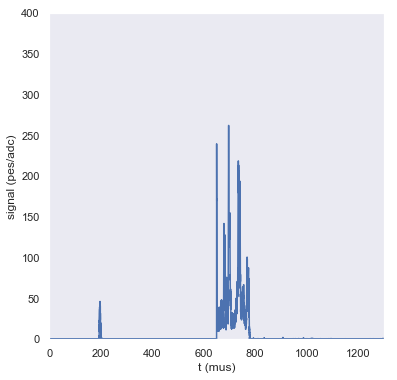

In [55]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

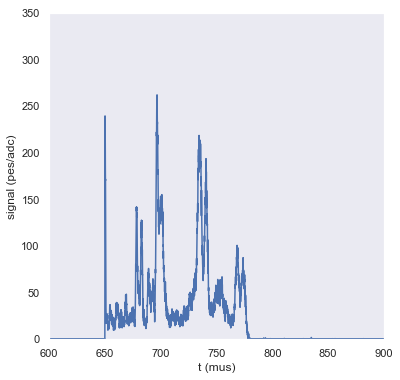

In [57]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 900,
                            signal_min =    0,
                            signal_max =  350,
                            figsize=(6,6))

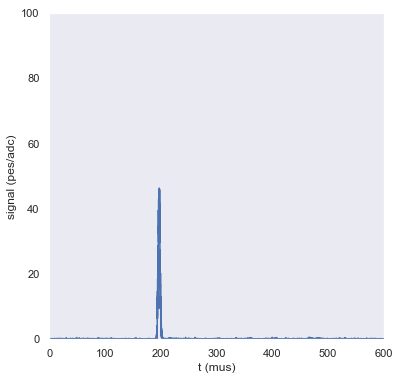

In [58]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [59]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [199.3   199.325 199.35  199.375 199.4  ] µs
 Time @ max energy: 199.35
 Width: 0.1 µs
 Height: 19.31949725062654 pes
 Energy: 90.6817147807392 pes
 Charge: 0.0 pes
 RMS: 0.03467243402985106 µs, 
        ---------------------
        S1 instance
        ---------------------
        Number of samples: 11
        Times: [199.6   199.625 199.65  199.675 199.7   199.725 199.75  199.775 199.8
 199.825 199.85 ] µs
        Time @ max energy: 199.65
        Width: 0.25 µs
        Height: 20.267811909533975 pes
        Energy: 156.0008918555861 pes
        Charge: 0.0 pes
        RMS: 0.07866889372789697 µs, 
        ---------------------
        S1 instance
        ---------------------
        Number of samples: 11
        Times: [200.5   200.525 200.55  200.575 200.6   200.625 200.65  200.675 200.7
 200.725 200.75 ] µs
        Time @ max energy: 200.725
        Width: 0.25 µs
        Height: 10.601289

In [60]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 11
        Times: [193.14688862 194.14239576 195.05637694 196.05060597 197.01277539
 197.99925522 198.96727096 199.92912084 200.90209806 202.09182971
 202.6076686 ] µs
        Time @ max energy: 197.01277538615224
        Width: 9.460779981708562 µs
        Height: 1628.289288500141 pes
        Energy: 7076.059507928918 pes
        Charge: 0.0 pes
        RMS: 1.6395320893157528 µs, 
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 130
        Times: [650.40585417 651.45081391 652.40072647 653.49038598 654.50089516
 655.44873437 656.44327814 657.45310692 658.4376323  659.51935792
 660.46118252 661.44167791 662.39809127 663.5092832  664.46230137
 665.44556536 666.44128194 667.50315173 668.48775075 669.41965953
 670.4520165  671.47039928 672.45631847 673.47283441 674.46163556
 675.44911556 676.42424641 677.60104956 678.4562

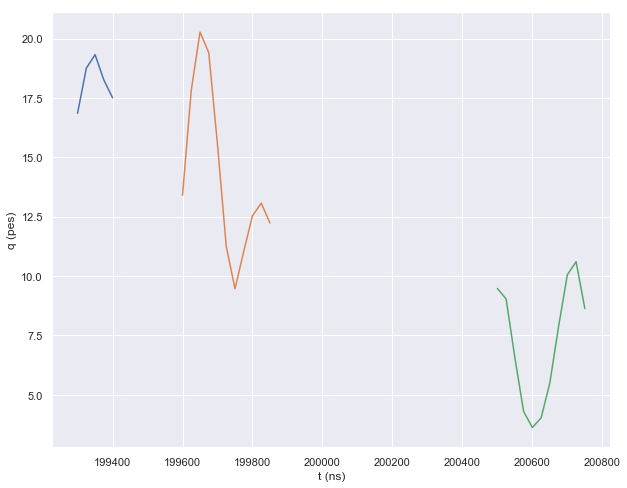

In [61]:
plot_S12(s1s)

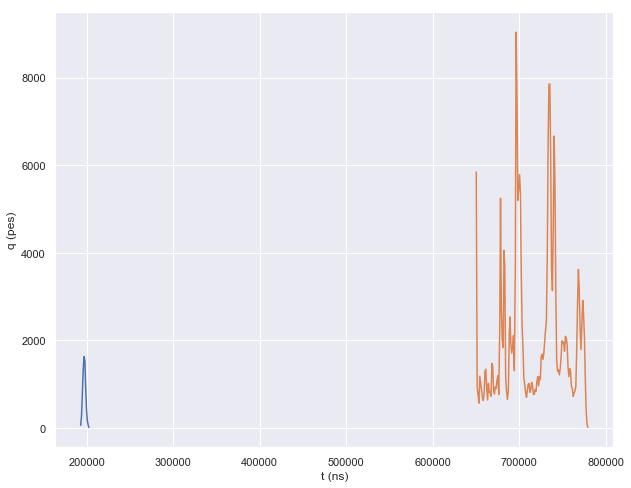

In [62]:
plot_S12(s2s)

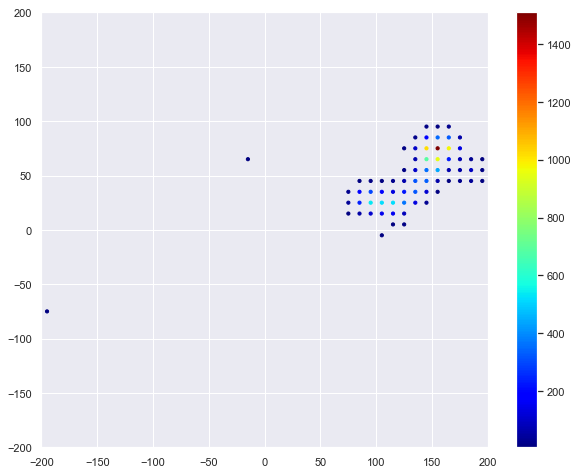

In [63]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

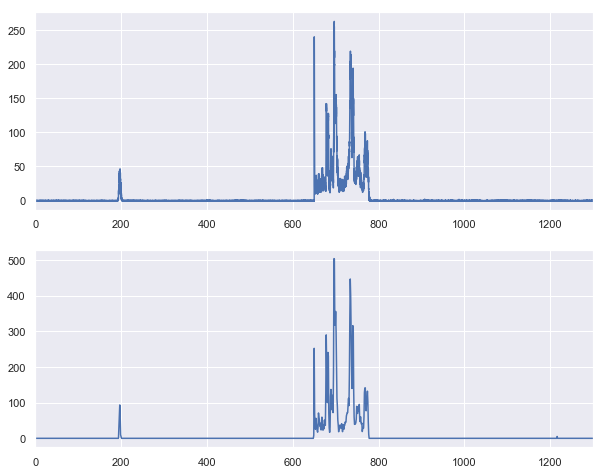

In [64]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 2

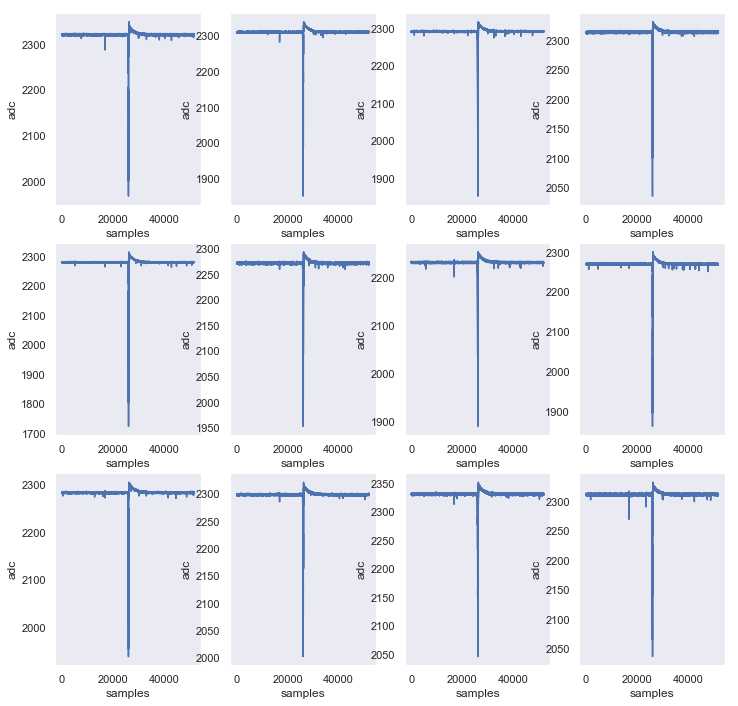

In [65]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

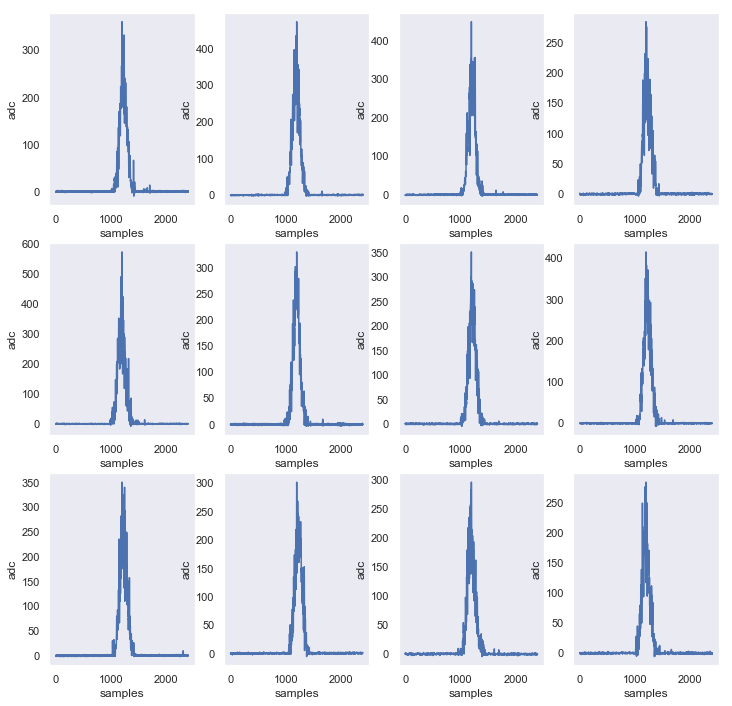

In [66]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [67]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


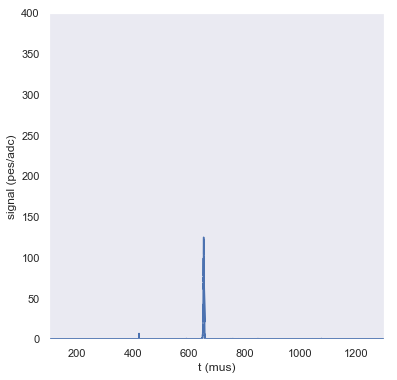

In [68]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

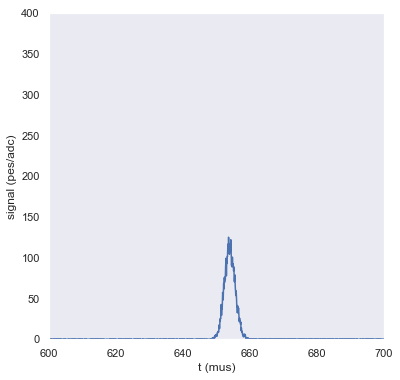

In [69]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

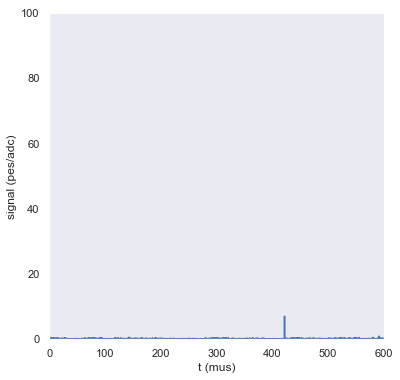

In [70]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [71]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
        ---------------------
        S1 instance
        ---------------------
        Number of samples: 15
        Times: [421.9   421.925 421.95  421.975 422.    422.025 422.05  422.075 422.1
 422.125 422.15  422.175 422.2   422.225 422.25 ] µs
        Time @ max energy: 421.95
        Width: 0.35 µs
        Height: 7.088196322558975 pes
        Energy: 34.45157979333355 pes
        Charge: 0.0 pes
        RMS: 0.07185671898765594 µs]

In [73]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 11
        Times: [649.27122915 650.21970018 651.23447582 652.18510986 653.16899533
 654.11898694 655.10200562 656.08317519 657.04618688 658.09994048
 659.02974793] µs
        Time @ max energy: 654.1189869357827
        Width: 9.758518786574248 µs
        Height: 4283.057516375515 pes
        Energy: 18230.88526558653 pes
        Charge: 0.0 pes
        RMS: 1.6107287431438988 µs]

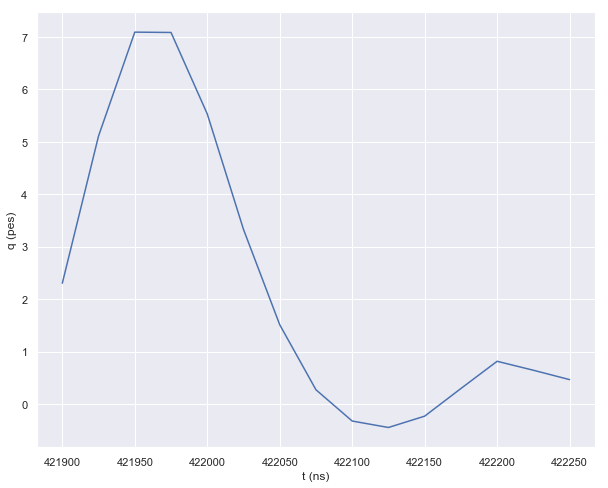

In [74]:
plot_S12(s1s)

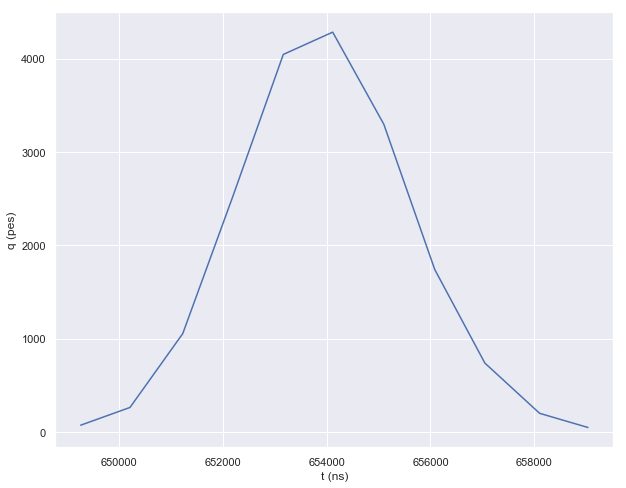

In [75]:
plot_S12(s2s)

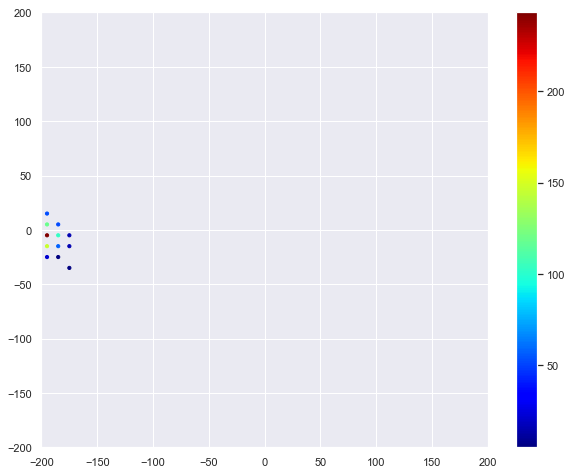

In [76]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

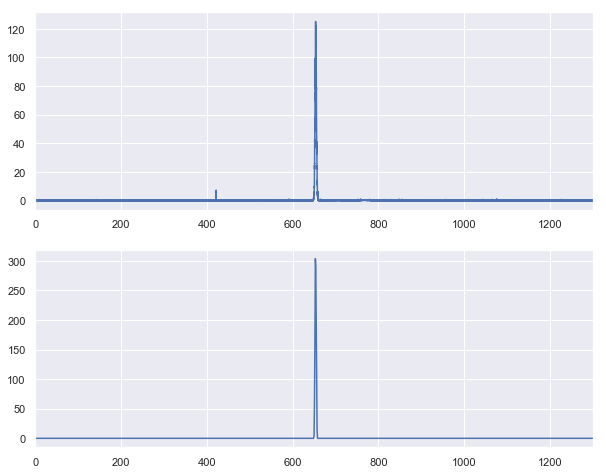

In [77]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 3

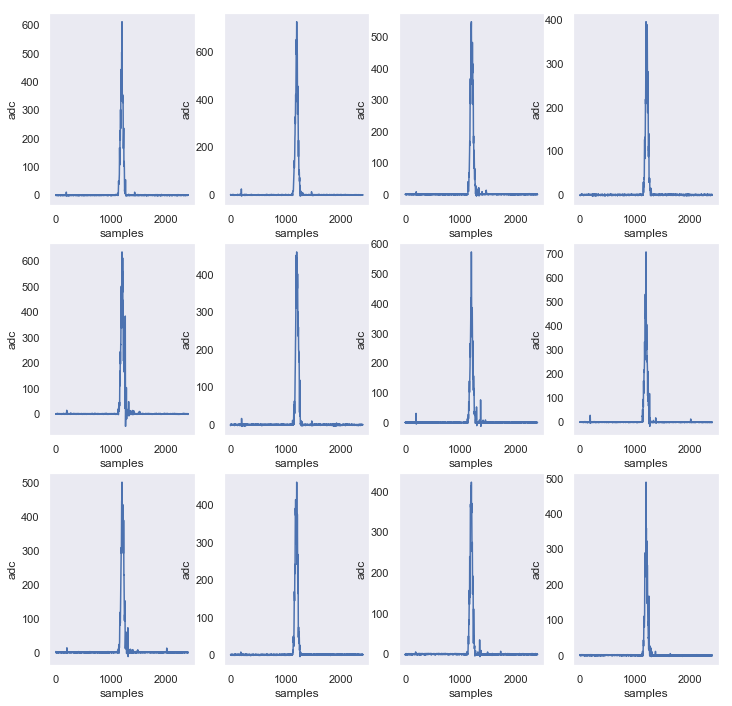

In [78]:
event=3
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


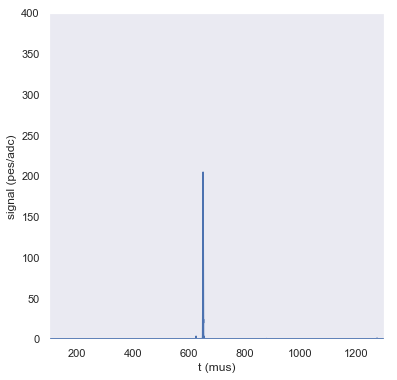

In [79]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

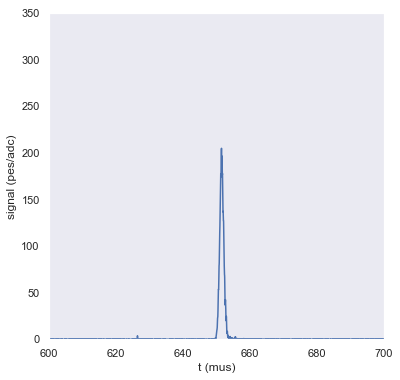

In [80]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  350,
                            figsize=(6,6))

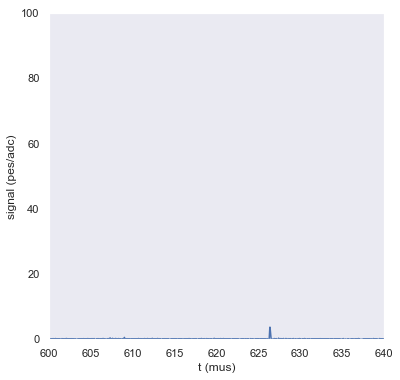

In [83]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 640,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [84]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[]

In [85]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 7
        Times: [650.40461112 651.23046231 652.01634708 652.89455527 654.03471947
 655.22774437 655.67227703] µs
        Time @ max energy: 651.2304623094448
        Width: 5.267665916468715 µs
        Height: 5642.927730851048 pes
        Energy: 11478.329233824677 pes
        Charge: 0.0 pes
        RMS: 0.5887010093497165 µs]

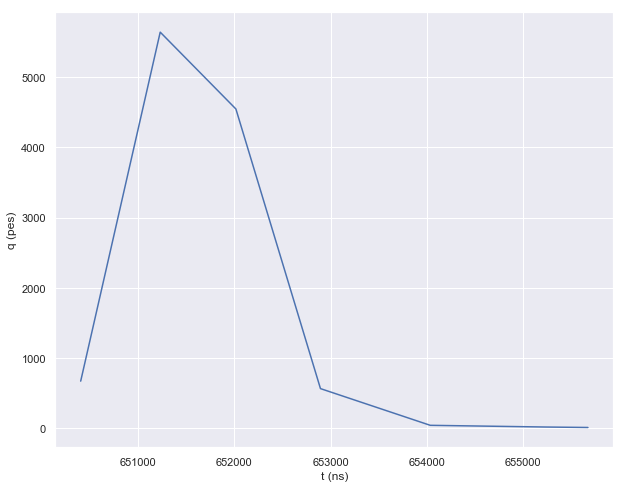

In [86]:
plot_S12(s2s)

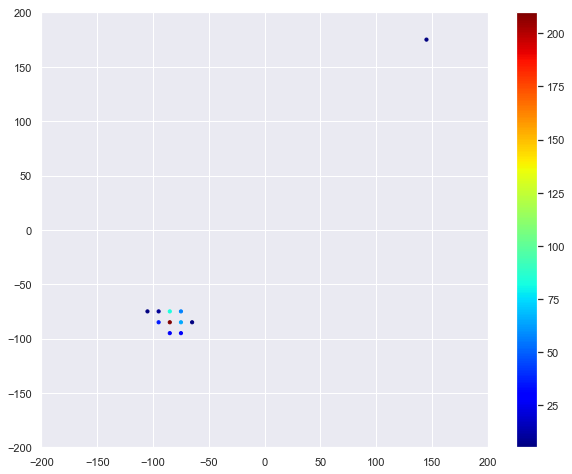

In [87]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

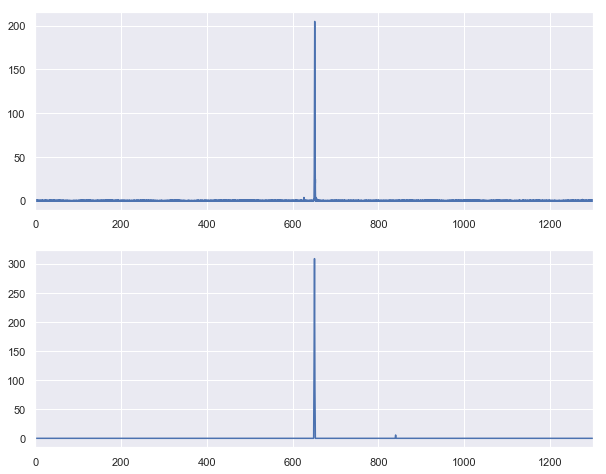

In [88]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 4

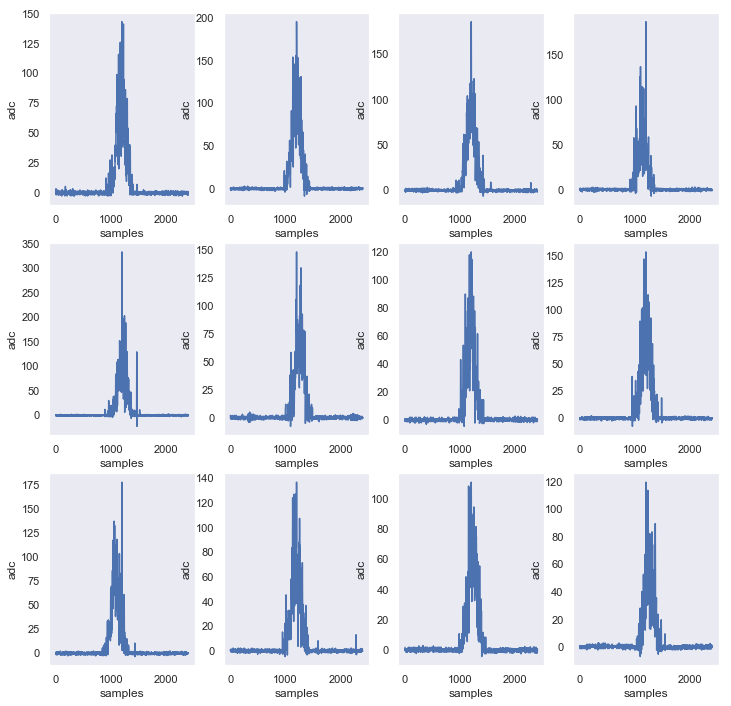

In [89]:
event=4
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


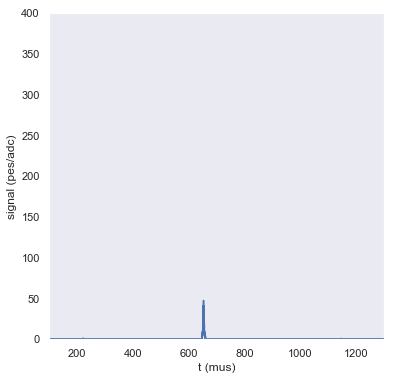

In [90]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

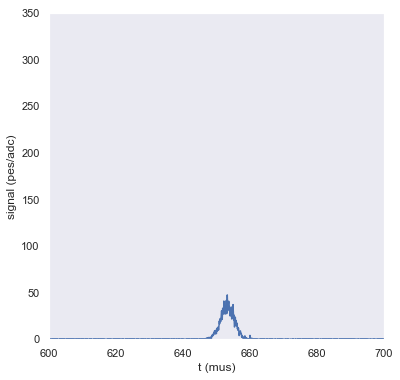

In [91]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  350,
                            figsize=(6,6))

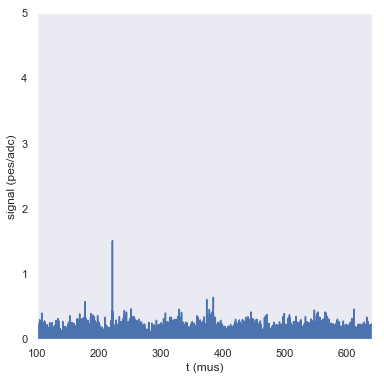

In [92]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 640,
                            signal_min =    0,
                            signal_max =  5,
                            figsize=(6,6))

In [93]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [221.675 221.7   221.725 221.75  221.775 221.8   221.825 221.85 ] µs
 Time @ max energy: 221.7
 Width: 0.175 µs
 Height: 1.509198929766588 pes
 Energy: 5.1660292002922255 pes
 Charge: 0.0 pes
 RMS: 0.05201059574551945 µs]

In [94]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 14
        Times: [647.68447902 648.78687798 649.69776921 650.74248312 651.69337113
 652.65769562 653.63196663 654.65272645 655.64214203 656.59828908
 657.52041211 658.54803493 659.9161226  660.65397974] µs
        Time @ max energy: 653.6319666331593
        Width: 12.969500721312826 µs
        Height: 1402.2094076748954 pes
        Energy: 7281.506185767003 pes
        Charge: 0.0 pes
        RMS: 2.0190316163343165 µs]

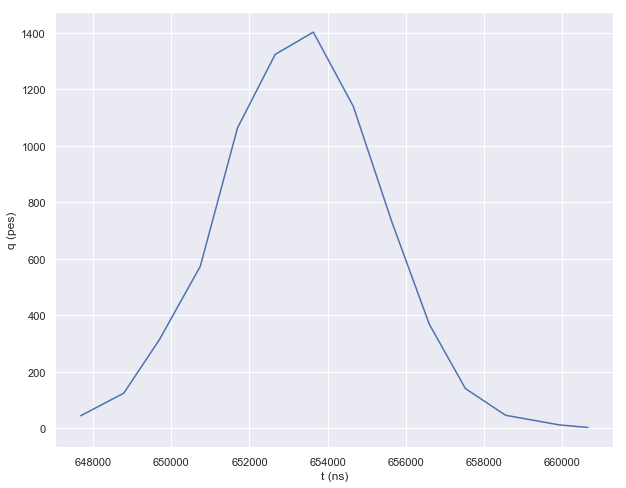

In [95]:
plot_S12(s2s)

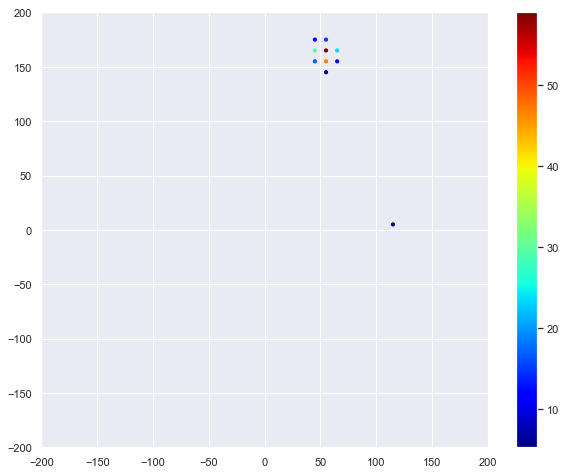

In [96]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

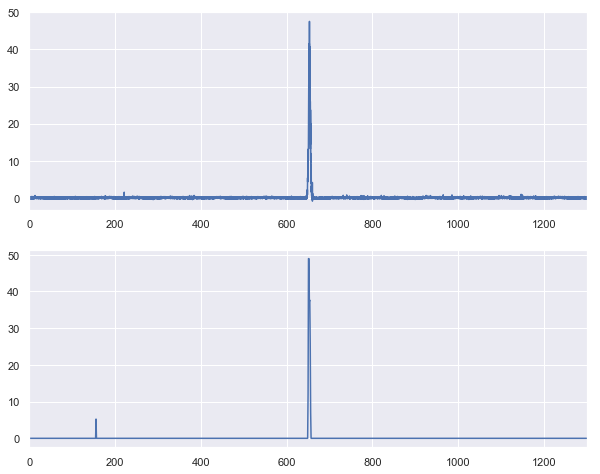

In [97]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 5

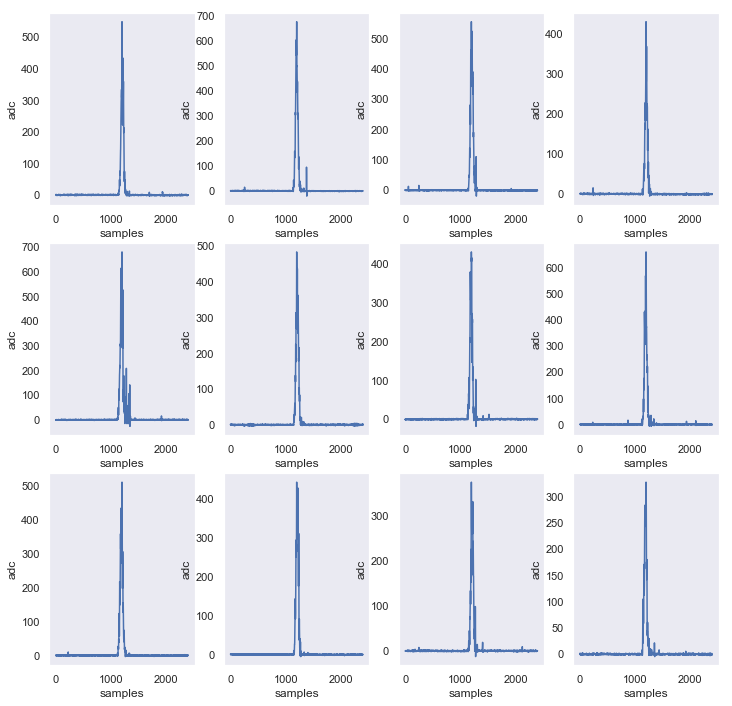

In [98]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


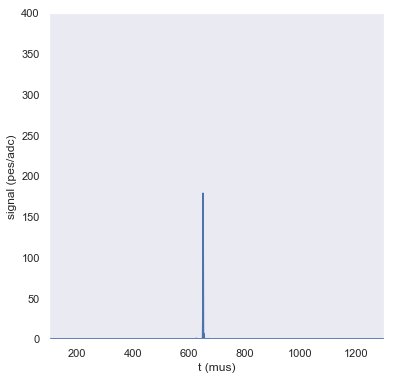

In [99]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


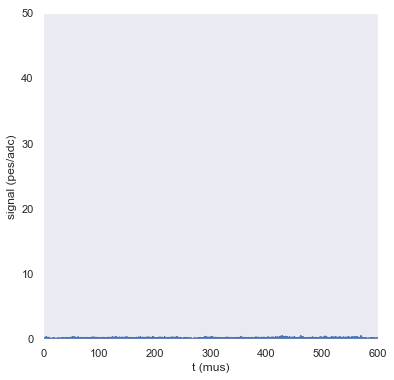

In [101]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  50,
                            figsize=(6,6))

In [102]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[]

In [103]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 7
        Times: [650.4020135  651.21255261 651.97133282 652.98923803 653.83679304
 655.07838858 655.8943524 ] µs
        Time @ max energy: 651.212552608175
        Width: 5.492338903148193 µs
        Height: 5455.243762372036 pes
        Energy: 9895.563561760599 pes
        Charge: 0.0 pes
        RMS: 0.5908422696128903 µs]

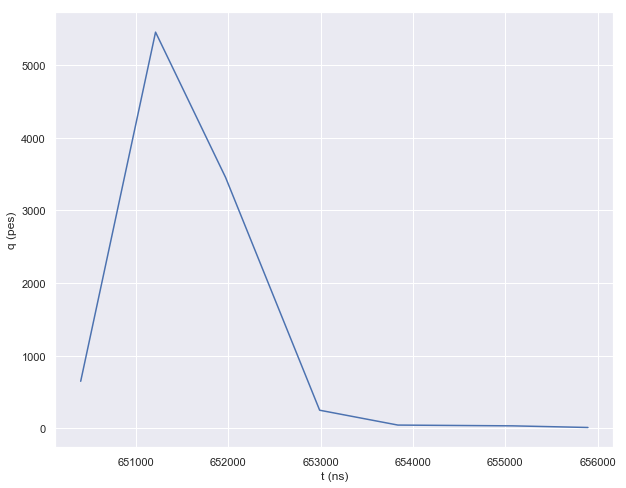

In [104]:
plot_S12(s2s)

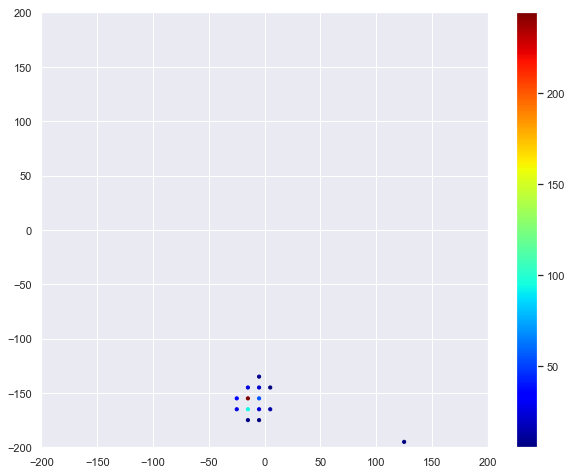

In [105]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

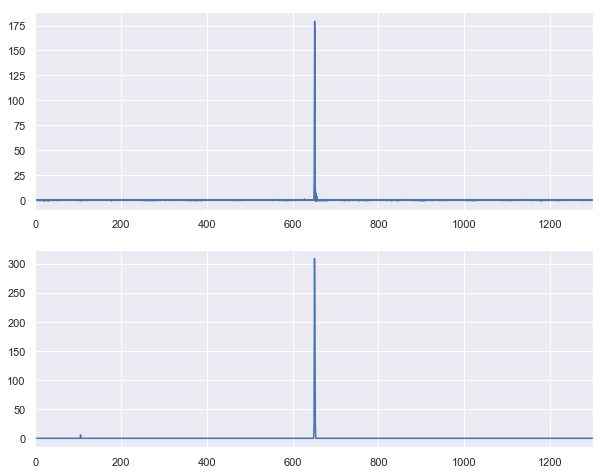

In [106]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 7

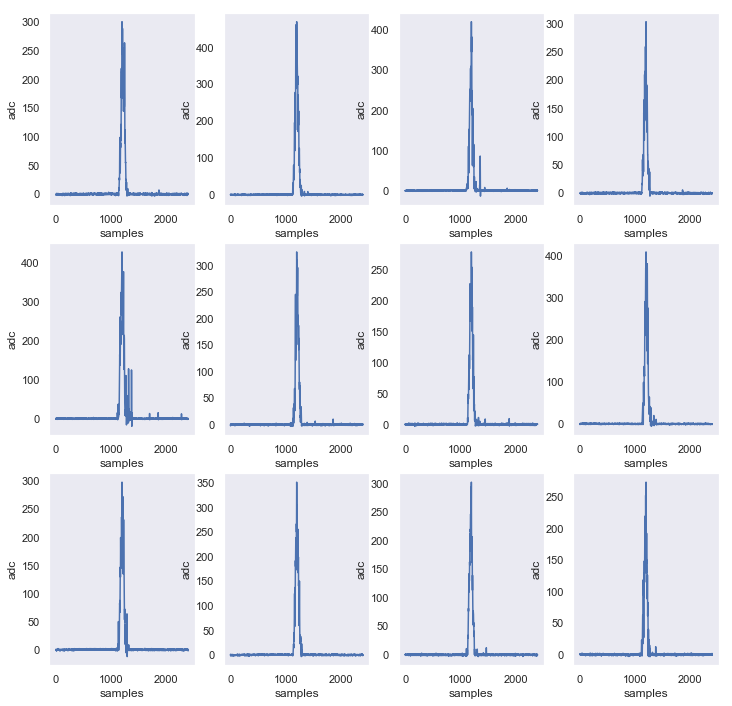

In [107]:
event=50
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


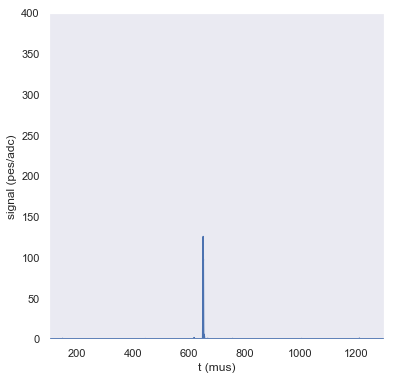

In [108]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  400,
                            figsize=(6,6))

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


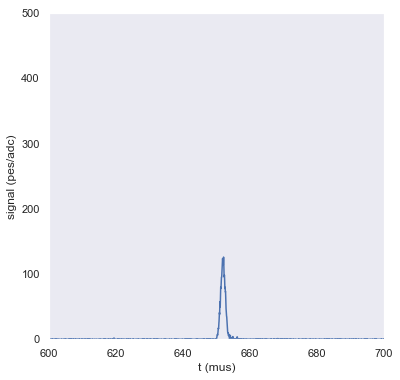

In [109]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      =700,
                            signal_min = 0,
                            signal_max =  500,
                            figsize=(6,6))

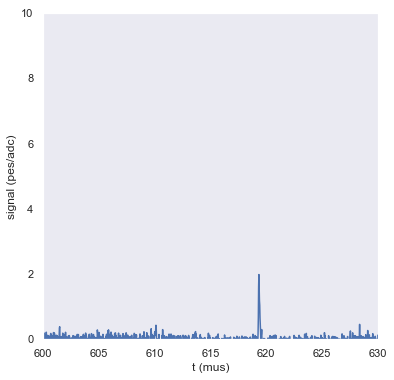

In [113]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      =630,
                            signal_min = 0,
                            signal_max =  10,
                            figsize=(6,6))

In [114]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [619.3   619.325 619.35  619.375 619.4   619.425 619.45  619.475] µs
 Time @ max energy: 619.35
 Width: 0.175 µs
 Height: 1.9836883311397175 pes
 Energy: 9.142914984114142 pes
 Charge: 0.0 pes
 RMS: 0.04728900884132387 µs]

In [115]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 5
 Times: [650.7054004  651.556701   652.39498276 653.25963107 654.401535  ] µs
 Time @ max energy: 651.5567009987647
 Width: 3.696134593880037 µs
 Height: 3777.8085783985284 pes
 Energy: 8264.462746513342 pes
 Charge: 0.0 pes
 RMS: 0.6537541423854821 µs]

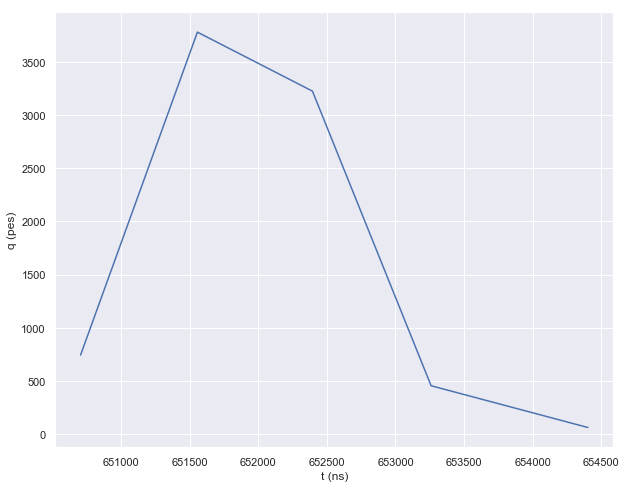

In [116]:
plot_S12(s2s)

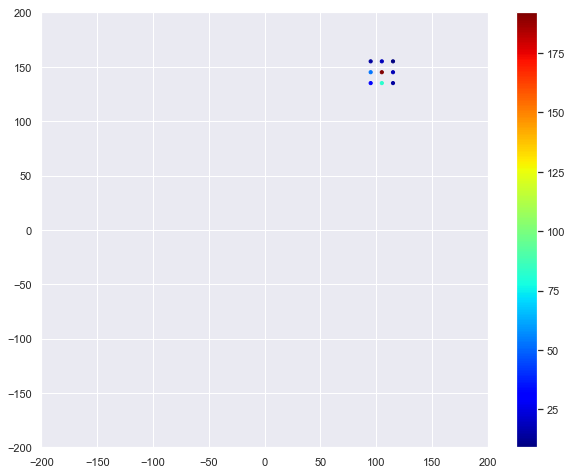

In [117]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

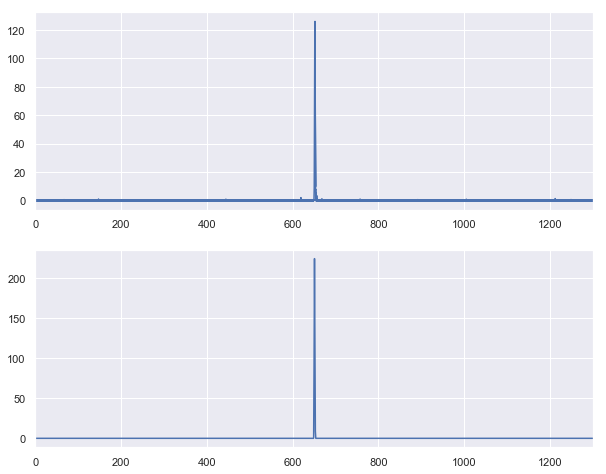

In [118]:
plot_pmt_and_sipm_sum_waveforms(cwf_sum, sipm_cal, t_min=0, t_max=1300)

## Event 8

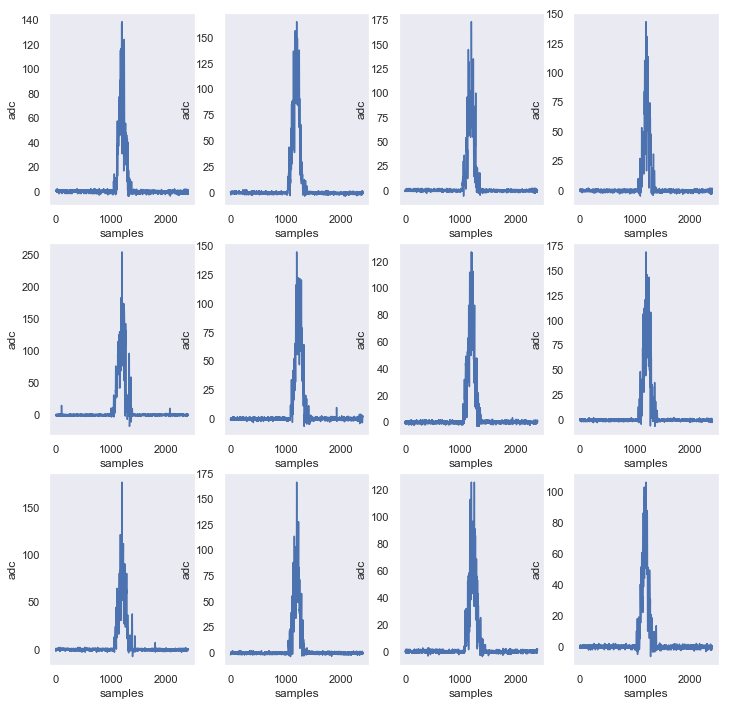

In [119]:
event=100
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [120]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [619.3   619.325 619.35  619.375 619.4   619.425 619.45  619.475] µs
 Time @ max energy: 619.35
 Width: 0.175 µs
 Height: 1.9836883311397175 pes
 Energy: 9.142914984114142 pes
 Charge: 0.0 pes
 RMS: 0.04728900884132387 µs]

In [121]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 5
 Times: [650.7054004  651.556701   652.39498276 653.25963107 654.401535  ] µs
 Time @ max energy: 651.5567009987647
 Width: 3.696134593880037 µs
 Height: 3777.8085783985284 pes
 Energy: 8264.462746513342 pes
 Charge: 0.0 pes
 RMS: 0.6537541423854821 µs]

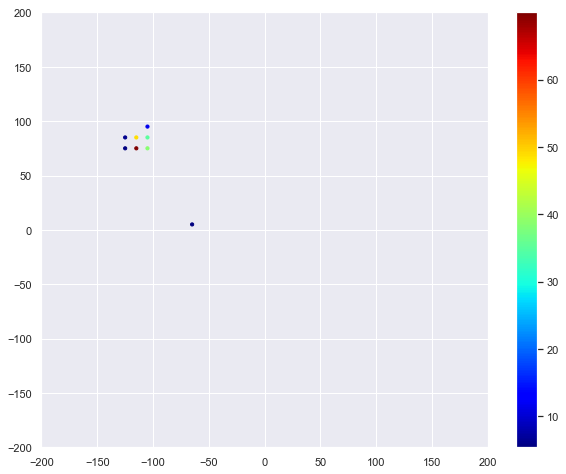

In [122]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 9

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


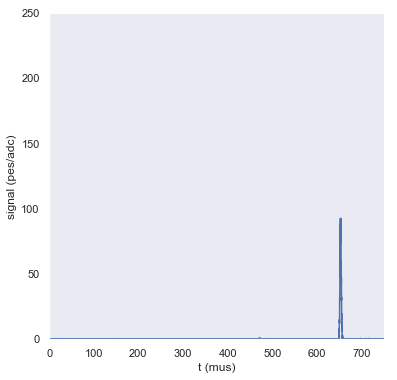

In [123]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [124]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [471.475 471.5   471.525 471.55  471.575] µs
 Time @ max energy: 471.55
 Width: 0.1 µs
 Height: 1.4136291910914272 pes
 Energy: 5.329015563209139 pes
 Charge: 0.0 pes
 RMS: 0.031685164791191725 µs]

In [125]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 9
        Times: [649.66127015 650.66776291 651.63393321 652.57475126 653.53809733
 654.51634459 655.45885733 656.3899681  657.45266182] µs
        Time @ max energy: 653.5380973263266
        Width: 7.791391666640877 µs
        Height: 3279.6283283248595 pes
        Energy: 12222.936626274306 pes
        Charge: 0.0 pes
        RMS: 1.3770424115724074 µs]

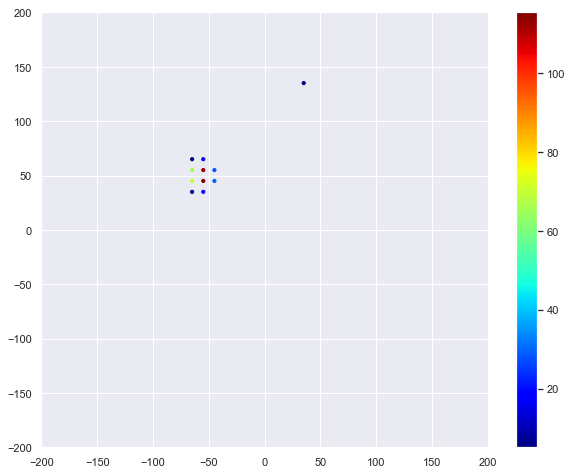

In [126]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)

## Event 10

/Users/jjgomezcadenas/miniconda/envs/IC-3.7-2018-08-29/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


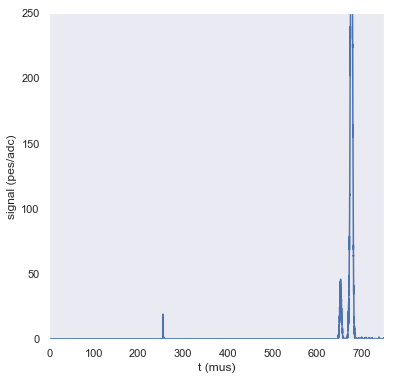

In [127]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [128]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
        ---------------------
        S1 instance
        ---------------------
        Number of samples: 17
        Times: [254.875 254.9   254.925 254.95  254.975 255.    255.025 255.05  255.075
 255.1   255.125 255.15  255.175 255.2   255.225 255.25  255.275] µs
        Time @ max energy: 254.95
        Width: 0.4 µs
        Height: 19.21016010835674 pes
        Energy: 109.60893908121169 pes
        Charge: 0.0 pes
        RMS: 0.08075752173498746 µs]

In [129]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 12
        Times: [647.83760359 648.93753861 649.91565233 650.88680139 651.86468072
 652.8433036  653.84737753 654.78483557 655.8011163  656.8434595
 657.69372785 658.50728174] µs
        Time @ max energy: 652.8433035997652
        Width: 10.669678153393907 µs
        Height: 1567.3653406697197 pes
        Energy: 7397.742578209253 pes
        Charge: 0.0 pes
        RMS: 1.9179943668324018 µs, 
        ---------------------
        S2 instance
        ---------------------
        Number of samples: 19
        Times: [667.78715006 668.66380618 669.75489426 670.70126255 671.71907902
 672.71946542 673.70714719 674.68954354 675.68500156 676.67503181
 677.66620255 678.64812974 679.62825479 680.61941942 681.5917308
 682.57418506 683.57806237 684.49539192 685.18932242] µs
        Time @ max energy: 677.6662025499351
        Width: 17.402172358951997 µs
        Height: 16878.78367012

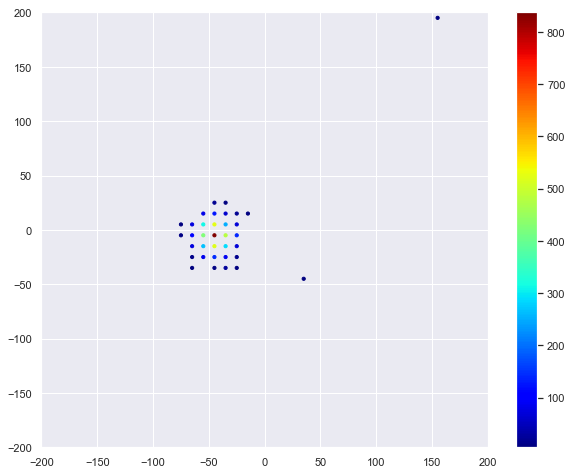

In [130]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)
plot_sipm_map(sipm_cal)